<a href="https://colab.research.google.com/github/philkun-jie/viewer-docs/blob/master/AlphaFold2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:240px">

##ColabFold v1.5.5: AlphaFold2 using MMseqs2

Easy to use protein structure and complex prediction using [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Sequence alignments/templates are generated through [MMseqs2](mmseqs.com) and [HHsearch](https://github.com/soedinglab/hh-suite). For more details, see <a href="#Instructions">bottom</a> of the notebook, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5).

Old versions: [v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/AlphaFold2.ipynb), [v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/AlphaFold2.ipynb), [v1.5.2](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.2/AlphaFold2.ipynb), [v1.5.3-patch](https://colab.research.google.com/github/sokrypton/ColabFold/blob/56c72044c7d51a311ca99b953a71e552fdc042e1/AlphaFold2.ipynb)

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

In [1]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'KVILYMEKENKKVSNRVAAAQAFRLTKCQRPVTQKLVQYA:CQSGECVPPGKVCDNVMDCLDKSDEGKACATTCEASNCTQECFRTPKGPHCSCRQGYYMERDQVTCSDVDECAWSEKLVCDHYCKNTKGGFQCSCHDKYILQTDNVTCKHQQSGSAFLLIAQDNGIRQLFLDDSRNVQIVHSENASTIGLGYDPITRTMFWSAFGVVLKAEVVPNAVSHSVLRDGIIVAEGLAVDWTGRNLYLTDPKIKHIIVCKMDGSSCYQLLRDLGHPRAIQLDMLNRYMYWSDVKDGTIRKAGMDGTNHDVVVMNGVVWPNAMALDLPAGRLYWLDANTDQAFSVKLDGTEQKSLQHAVIHHPFAMVLWEDRLYWTDWSEKVISSCVKRDGRHGKTVLKGFTMYFGLVLFHPAMMEDISNPCQYSNCSHMCLLSPHPPGYACACPSGIMELSLDRHTCVDTPARVYLIVSSLKKLYLLSPHKFGRADQHVLEPHPDIKDIGDVEYSPEQDMVLVSDQWYSKVYAIYMETARVITLMQNTVVRRMALDWLRNNLYWLSANHEVLVGKIKEDEVTFHSVVIANLQSPLDIAVAPLLGYLFVSGASSRLKTAYIKQCGLDGSQCTTLVSEGIEKPISLTMDHWHNYLYWCDYMLMTMERIKMDGTNRVAIIDSNSRVVGRKSVKSLMVTDDRIYFTLEGKLAVYAISNDTSNPDLQMVKLDIDPQEGEILRLNRLKWKPPSYQGSQKPCFNNGGCSDICVGNASQDEVCLCGLSSQLEENGKTCKKRKCGDHMYECADSSECISLAWKCDGATDCIDGSDEVDCPFKCPPDYYQCNTTDHCVHKDKVCDGHEDCNDGSDEKDSCHKAPPDTCPGHVCD' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = 'pair2' #@param {type:"string"}
# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "none" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))

jobname pair2_b837a
sequence KVILYMEKENKKVSNRVAAAQAFRLTKCQRPVTQKLVQYA:CQSGECVPPGKVCDNVMDCLDKSDEGKACATTCEASNCTQECFRTPKGPHCSCRQGYYMERDQVTCSDVDECAWSEKLVCDHYCKNTKGGFQCSCHDKYILQTDNVTCKHQQSGSAFLLIAQDNGIRQLFLDDSRNVQIVHSENASTIGLGYDPITRTMFWSAFGVVLKAEVVPNAVSHSVLRDGIIVAEGLAVDWTGRNLYLTDPKIKHIIVCKMDGSSCYQLLRDLGHPRAIQLDMLNRYMYWSDVKDGTIRKAGMDGTNHDVVVMNGVVWPNAMALDLPAGRLYWLDANTDQAFSVKLDGTEQKSLQHAVIHHPFAMVLWEDRLYWTDWSEKVISSCVKRDGRHGKTVLKGFTMYFGLVLFHPAMMEDISNPCQYSNCSHMCLLSPHPPGYACACPSGIMELSLDRHTCVDTPARVYLIVSSLKKLYLLSPHKFGRADQHVLEPHPDIKDIGDVEYSPEQDMVLVSDQWYSKVYAIYMETARVITLMQNTVVRRMALDWLRNNLYWLSANHEVLVGKIKEDEVTFHSVVIANLQSPLDIAVAPLLGYLFVSGASSRLKTAYIKQCGLDGSQCTTLVSEGIEKPISLTMDHWHNYLYWCDYMLMTMERIKMDGTNRVAIIDSNSRVVGRKSVKSLMVTDDRIYFTLEGKLAVYAISNDTSNPDLQMVKLDIDPQEGEILRLNRLKWKPPSYQGSQKPCFNNGGCSDICVGNASQDEVCLCGLSSQLEENGKTCKKRKCGDHMYECADSSECISLAWKCDGATDCIDGSDEVDCPFKCPPDYYQCNTTDHCVHKDKVCDGHEDCNDGSDEKDSCHKAPPDTCPGHVCD
length 869


In [2]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # hack to fix TF crash
  os.system("rm -f /usr/local/lib/python3.*/dist-packages/tensorflow/core/kernels/libtfkernel_sobol_op.so")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

installing colabfold...
CPU times: user 1.64 ms, sys: 1 ms, total: 2.64 ms
Wall time: 29 s


In [3]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [4]:
#@markdown ### Advanced settings
model_type = "alphafold2_multimer_v3" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "6" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.
calc_extra_ptm = False #@param {type:"boolean"}
#@markdown - return pairwise chain iptm/actifptm

#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 4 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = True #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = True #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

2025-08-18 07:43:03,562 Running on GPU
2025-08-18 07:43:03,835 Found 5 citations for tools or databases
2025-08-18 07:43:03,835 Query 1/1: pair2_b837a (length 869)


COMPLETE: 100%|██████████| 300/300 [elapsed: 00:00 remaining: 00:00]


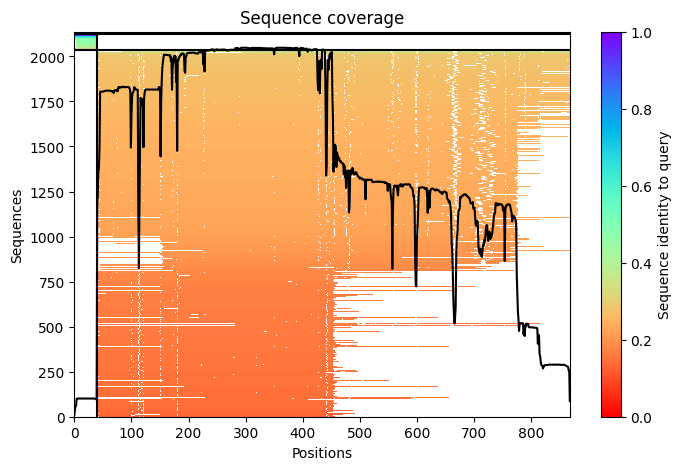

2025-08-18 07:43:12,100 Setting max_seq=508, max_extra_seq=1629
2025-08-18 07:47:03,896 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=82 pTM=0.677 ipTM=0.326
2025-08-18 07:48:46,106 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=81.5 pTM=0.689 ipTM=0.281 tol=2.89
2025-08-18 07:49:01,092 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=82.4 pTM=0.725 ipTM=0.362 tol=1.23
2025-08-18 07:49:16,046 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=82.4 pTM=0.735 ipTM=0.371 tol=0.979
2025-08-18 07:49:31,004 alphafold2_multimer_v3_model_1_seed_000 recycle=4 pLDDT=82.4 pTM=0.741 ipTM=0.339 tol=0.655
2025-08-18 07:49:45,961 alphafold2_multimer_v3_model_1_seed_000 recycle=5 pLDDT=82.6 pTM=0.736 ipTM=0.383 tol=0.827
2025-08-18 07:50:00,939 alphafold2_multimer_v3_model_1_seed_000 recycle=6 pLDDT=82.8 pTM=0.742 ipTM=0.369 tol=0.868
2025-08-18 07:50:00,940 alphafold2_multimer_v3_model_1_seed_000 took 400.4s (6 recycles)


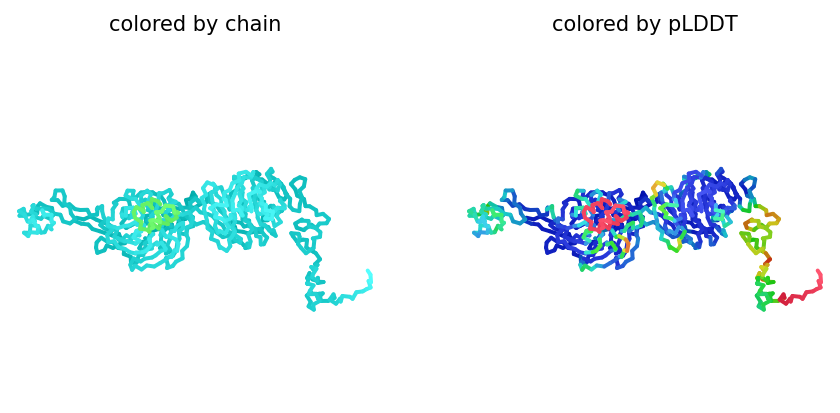

2025-08-18 07:50:17,453 alphafold2_multimer_v3_model_2_seed_000 recycle=0 pLDDT=81.4 pTM=0.715 ipTM=0.547
2025-08-18 07:50:32,473 alphafold2_multimer_v3_model_2_seed_000 recycle=1 pLDDT=83.6 pTM=0.746 ipTM=0.541 tol=8.41
2025-08-18 07:50:47,511 alphafold2_multimer_v3_model_2_seed_000 recycle=2 pLDDT=83.8 pTM=0.759 ipTM=0.572 tol=1.56
2025-08-18 07:51:02,517 alphafold2_multimer_v3_model_2_seed_000 recycle=3 pLDDT=83.9 pTM=0.759 ipTM=0.472 tol=1.95
2025-08-18 07:51:17,528 alphafold2_multimer_v3_model_2_seed_000 recycle=4 pLDDT=83.9 pTM=0.766 ipTM=0.442 tol=1.17
2025-08-18 07:51:32,544 alphafold2_multimer_v3_model_2_seed_000 recycle=5 pLDDT=84 pTM=0.757 ipTM=0.343 tol=1.33
2025-08-18 07:51:47,574 alphafold2_multimer_v3_model_2_seed_000 recycle=6 pLDDT=84.1 pTM=0.755 ipTM=0.361 tol=0.691
2025-08-18 07:51:47,575 alphafold2_multimer_v3_model_2_seed_000 took 105.2s (6 recycles)


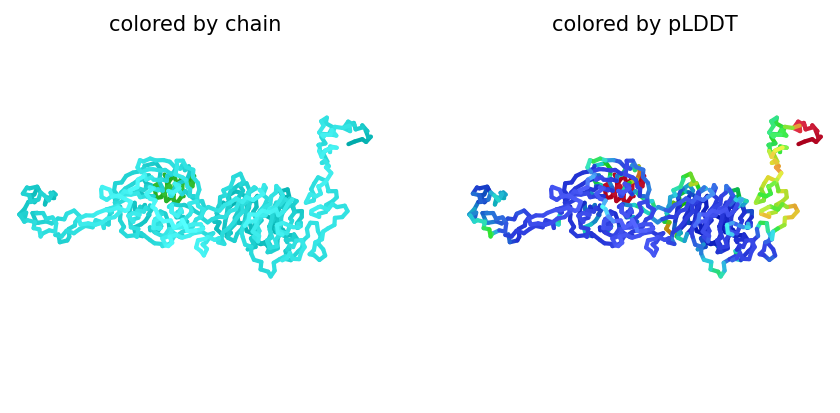

2025-08-18 07:52:04,089 alphafold2_multimer_v3_model_3_seed_000 recycle=0 pLDDT=82.7 pTM=0.685 ipTM=0.48
2025-08-18 07:52:19,041 alphafold2_multimer_v3_model_3_seed_000 recycle=1 pLDDT=82.4 pTM=0.701 ipTM=0.478 tol=1.62
2025-08-18 07:52:33,988 alphafold2_multimer_v3_model_3_seed_000 recycle=2 pLDDT=82.1 pTM=0.72 ipTM=0.504 tol=1.44
2025-08-18 07:52:48,923 alphafold2_multimer_v3_model_3_seed_000 recycle=3 pLDDT=82.3 pTM=0.727 ipTM=0.543 tol=0.572
2025-08-18 07:53:03,876 alphafold2_multimer_v3_model_3_seed_000 recycle=4 pLDDT=82.8 pTM=0.734 ipTM=0.528 tol=0.598
2025-08-18 07:53:18,854 alphafold2_multimer_v3_model_3_seed_000 recycle=5 pLDDT=82.9 pTM=0.735 ipTM=0.527 tol=0.718
2025-08-18 07:53:33,832 alphafold2_multimer_v3_model_3_seed_000 recycle=6 pLDDT=83.2 pTM=0.732 ipTM=0.533 tol=0.587
2025-08-18 07:53:33,832 alphafold2_multimer_v3_model_3_seed_000 took 104.8s (6 recycles)


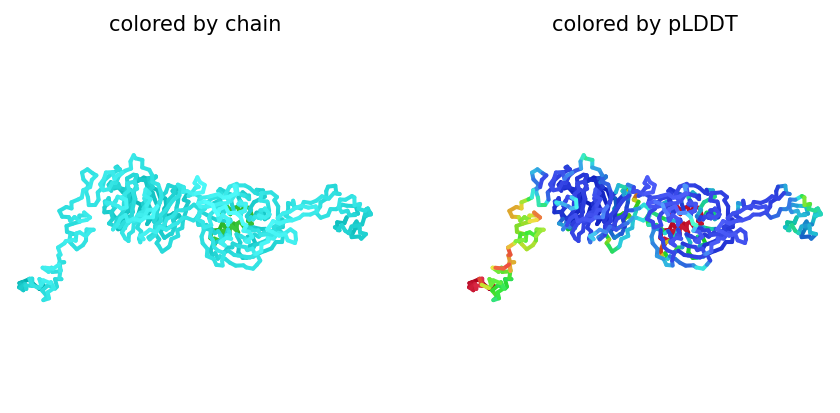

2025-08-18 07:53:50,320 alphafold2_multimer_v3_model_4_seed_000 recycle=0 pLDDT=81.2 pTM=0.669 ipTM=0.353
2025-08-18 07:54:05,260 alphafold2_multimer_v3_model_4_seed_000 recycle=1 pLDDT=81.4 pTM=0.696 ipTM=0.361 tol=6.02
2025-08-18 07:54:20,181 alphafold2_multimer_v3_model_4_seed_000 recycle=2 pLDDT=81.2 pTM=0.72 ipTM=0.346 tol=3.81
2025-08-18 07:54:35,165 alphafold2_multimer_v3_model_4_seed_000 recycle=3 pLDDT=83.1 pTM=0.75 ipTM=0.475 tol=0.896
2025-08-18 07:54:50,124 alphafold2_multimer_v3_model_4_seed_000 recycle=4 pLDDT=82.3 pTM=0.745 ipTM=0.428 tol=0.531
2025-08-18 07:55:05,122 alphafold2_multimer_v3_model_4_seed_000 recycle=5 pLDDT=83.4 pTM=0.755 ipTM=0.448 tol=0.525
2025-08-18 07:55:20,118 alphafold2_multimer_v3_model_4_seed_000 recycle=6 pLDDT=83.5 pTM=0.761 ipTM=0.514 tol=0.555
2025-08-18 07:55:20,119 alphafold2_multimer_v3_model_4_seed_000 took 104.8s (6 recycles)


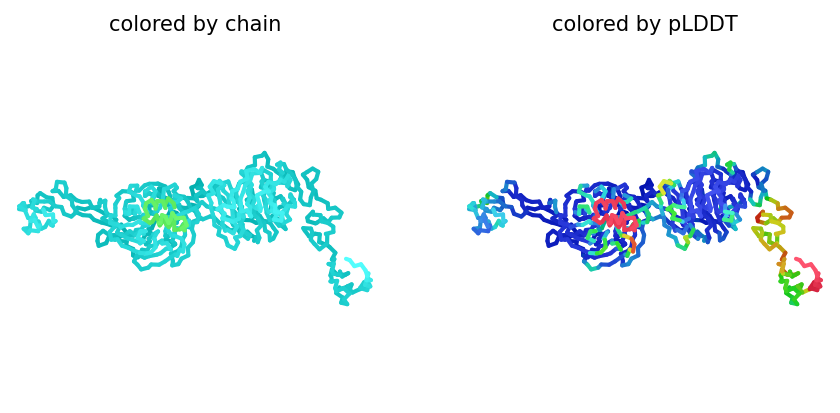

2025-08-18 07:55:36,616 alphafold2_multimer_v3_model_5_seed_000 recycle=0 pLDDT=81.1 pTM=0.713 ipTM=0.502
2025-08-18 07:55:51,568 alphafold2_multimer_v3_model_5_seed_000 recycle=1 pLDDT=80.5 pTM=0.709 ipTM=0.422 tol=2.11
2025-08-18 07:56:06,530 alphafold2_multimer_v3_model_5_seed_000 recycle=2 pLDDT=81.3 pTM=0.733 ipTM=0.488 tol=3.4
2025-08-18 07:56:21,486 alphafold2_multimer_v3_model_5_seed_000 recycle=3 pLDDT=81.3 pTM=0.737 ipTM=0.515 tol=0.76
2025-08-18 07:56:36,482 alphafold2_multimer_v3_model_5_seed_000 recycle=4 pLDDT=82.4 pTM=0.75 ipTM=0.522 tol=0.83
2025-08-18 07:56:51,479 alphafold2_multimer_v3_model_5_seed_000 recycle=5 pLDDT=82.6 pTM=0.751 ipTM=0.522 tol=0.746
2025-08-18 07:57:06,486 alphafold2_multimer_v3_model_5_seed_000 recycle=6 pLDDT=82.8 pTM=0.751 ipTM=0.493 tol=1.29
2025-08-18 07:57:06,487 alphafold2_multimer_v3_model_5_seed_000 took 104.9s (6 recycles)


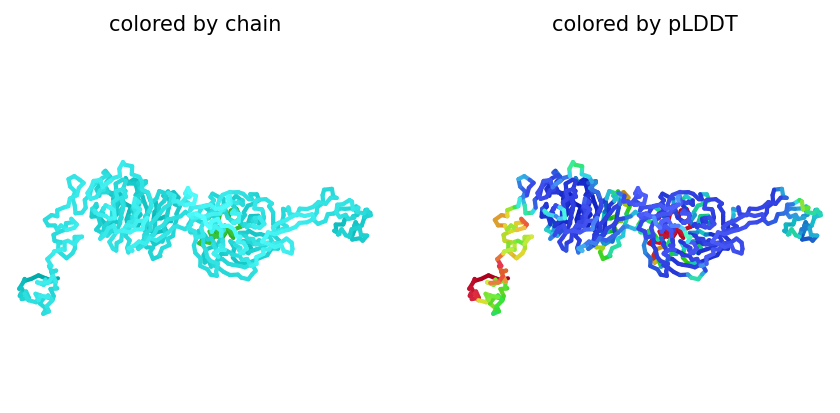

2025-08-18 07:57:22,945 alphafold2_multimer_v3_model_1_seed_001 recycle=0 pLDDT=80.1 pTM=0.639 ipTM=0.256
2025-08-18 07:57:37,887 alphafold2_multimer_v3_model_1_seed_001 recycle=1 pLDDT=81.2 pTM=0.703 ipTM=0.359 tol=3.98
2025-08-18 07:57:52,846 alphafold2_multimer_v3_model_1_seed_001 recycle=2 pLDDT=82.5 pTM=0.738 ipTM=0.421 tol=2.15
2025-08-18 07:58:07,810 alphafold2_multimer_v3_model_1_seed_001 recycle=3 pLDDT=83.3 pTM=0.752 ipTM=0.454 tol=1.15
2025-08-18 07:58:22,794 alphafold2_multimer_v3_model_1_seed_001 recycle=4 pLDDT=83.7 pTM=0.764 ipTM=0.5 tol=0.989
2025-08-18 07:58:37,744 alphafold2_multimer_v3_model_1_seed_001 recycle=5 pLDDT=83.4 pTM=0.755 ipTM=0.458 tol=0.886
2025-08-18 07:58:52,678 alphafold2_multimer_v3_model_1_seed_001 recycle=6 pLDDT=82.9 pTM=0.751 ipTM=0.452 tol=1.2
2025-08-18 07:58:52,678 alphafold2_multimer_v3_model_1_seed_001 took 104.8s (6 recycles)


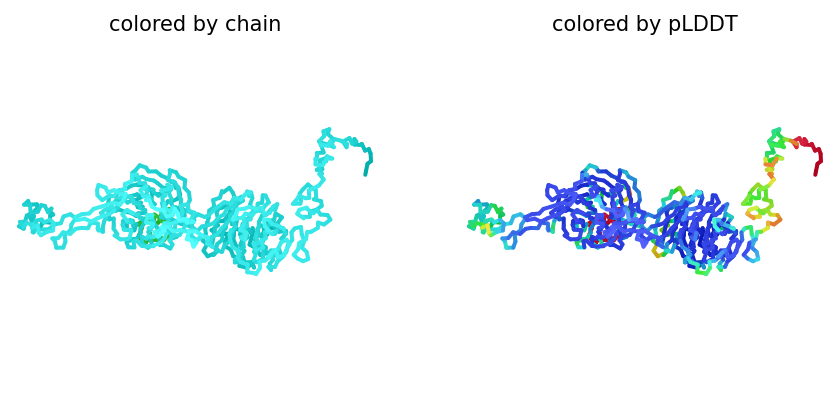

2025-08-18 07:59:09,168 alphafold2_multimer_v3_model_2_seed_001 recycle=0 pLDDT=80.6 pTM=0.659 ipTM=0.395
2025-08-18 07:59:24,162 alphafold2_multimer_v3_model_2_seed_001 recycle=1 pLDDT=82.8 pTM=0.715 ipTM=0.452 tol=5.67
2025-08-18 07:59:39,176 alphafold2_multimer_v3_model_2_seed_001 recycle=2 pLDDT=83.9 pTM=0.757 ipTM=0.462 tol=2.45
2025-08-18 07:59:54,196 alphafold2_multimer_v3_model_2_seed_001 recycle=3 pLDDT=84.5 pTM=0.761 ipTM=0.437 tol=1.57
2025-08-18 08:00:09,221 alphafold2_multimer_v3_model_2_seed_001 recycle=4 pLDDT=84.4 pTM=0.766 ipTM=0.427 tol=0.889
2025-08-18 08:00:24,273 alphafold2_multimer_v3_model_2_seed_001 recycle=5 pLDDT=84.5 pTM=0.765 ipTM=0.431 tol=1.36
2025-08-18 08:00:39,275 alphafold2_multimer_v3_model_2_seed_001 recycle=6 pLDDT=83.8 pTM=0.754 ipTM=0.402 tol=1.53
2025-08-18 08:00:39,276 alphafold2_multimer_v3_model_2_seed_001 took 105.2s (6 recycles)


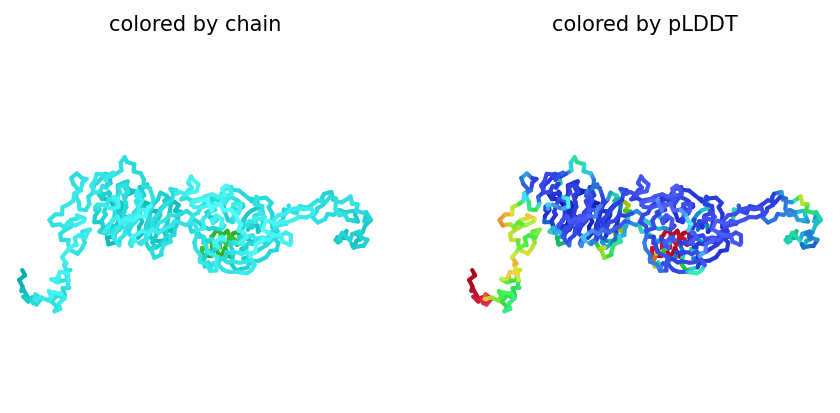

2025-08-18 08:00:55,786 alphafold2_multimer_v3_model_3_seed_001 recycle=0 pLDDT=81.6 pTM=0.638 ipTM=0.33
2025-08-18 08:01:10,719 alphafold2_multimer_v3_model_3_seed_001 recycle=1 pLDDT=81.1 pTM=0.672 ipTM=0.392 tol=2.28
2025-08-18 08:01:25,679 alphafold2_multimer_v3_model_3_seed_001 recycle=2 pLDDT=82.8 pTM=0.737 ipTM=0.48 tol=1.92
2025-08-18 08:01:40,643 alphafold2_multimer_v3_model_3_seed_001 recycle=3 pLDDT=83.4 pTM=0.741 ipTM=0.483 tol=0.813
2025-08-18 08:01:55,616 alphafold2_multimer_v3_model_3_seed_001 recycle=4 pLDDT=83.2 pTM=0.751 ipTM=0.506 tol=0.959
2025-08-18 08:02:10,592 alphafold2_multimer_v3_model_3_seed_001 recycle=5 pLDDT=83.3 pTM=0.748 ipTM=0.505 tol=1.25
2025-08-18 08:02:25,519 alphafold2_multimer_v3_model_3_seed_001 recycle=6 pLDDT=82.1 pTM=0.734 ipTM=0.473 tol=1.5
2025-08-18 08:02:25,520 alphafold2_multimer_v3_model_3_seed_001 took 104.8s (6 recycles)


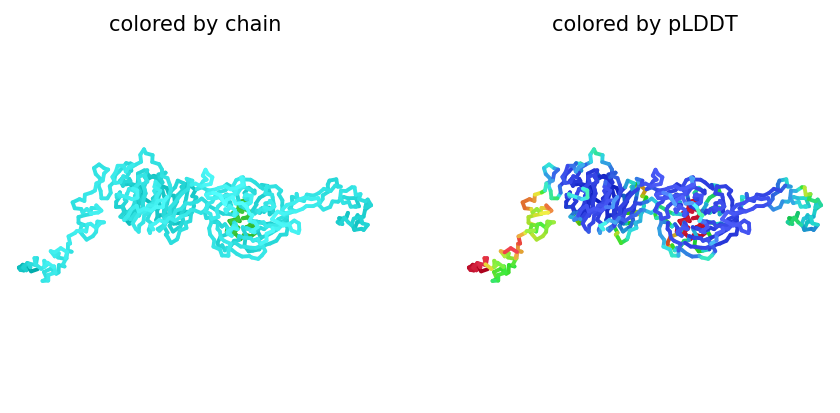

2025-08-18 08:02:41,992 alphafold2_multimer_v3_model_4_seed_001 recycle=0 pLDDT=80.2 pTM=0.635 ipTM=0.173
2025-08-18 08:02:56,976 alphafold2_multimer_v3_model_4_seed_001 recycle=1 pLDDT=81.8 pTM=0.706 ipTM=0.285 tol=6.75
2025-08-18 08:03:11,958 alphafold2_multimer_v3_model_4_seed_001 recycle=2 pLDDT=83 pTM=0.744 ipTM=0.385 tol=1.56
2025-08-18 08:03:26,938 alphafold2_multimer_v3_model_4_seed_001 recycle=3 pLDDT=83.2 pTM=0.745 ipTM=0.394 tol=1.43
2025-08-18 08:03:41,912 alphafold2_multimer_v3_model_4_seed_001 recycle=4 pLDDT=82.7 pTM=0.752 ipTM=0.424 tol=0.887
2025-08-18 08:03:56,928 alphafold2_multimer_v3_model_4_seed_001 recycle=5 pLDDT=84.1 pTM=0.763 ipTM=0.462 tol=1.67
2025-08-18 08:04:11,880 alphafold2_multimer_v3_model_4_seed_001 recycle=6 pLDDT=82.4 pTM=0.744 ipTM=0.349 tol=1.79
2025-08-18 08:04:11,881 alphafold2_multimer_v3_model_4_seed_001 took 104.9s (6 recycles)


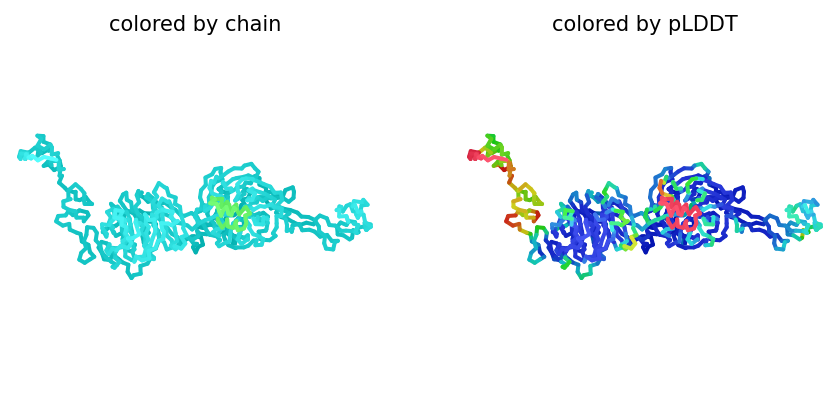

2025-08-18 08:04:28,339 alphafold2_multimer_v3_model_5_seed_001 recycle=0 pLDDT=79.4 pTM=0.652 ipTM=0.231
2025-08-18 08:04:43,308 alphafold2_multimer_v3_model_5_seed_001 recycle=1 pLDDT=80.5 pTM=0.688 ipTM=0.448 tol=4.65
2025-08-18 08:04:58,307 alphafold2_multimer_v3_model_5_seed_001 recycle=2 pLDDT=82.4 pTM=0.743 ipTM=0.431 tol=3.46
2025-08-18 08:05:13,298 alphafold2_multimer_v3_model_5_seed_001 recycle=3 pLDDT=82.6 pTM=0.744 ipTM=0.494 tol=1.51
2025-08-18 08:05:28,307 alphafold2_multimer_v3_model_5_seed_001 recycle=4 pLDDT=82.9 pTM=0.758 ipTM=0.509 tol=1.04
2025-08-18 08:05:43,297 alphafold2_multimer_v3_model_5_seed_001 recycle=5 pLDDT=82.4 pTM=0.753 ipTM=0.477 tol=0.59
2025-08-18 08:05:58,234 alphafold2_multimer_v3_model_5_seed_001 recycle=6 pLDDT=81.2 pTM=0.738 ipTM=0.453 tol=1.21
2025-08-18 08:05:58,234 alphafold2_multimer_v3_model_5_seed_001 took 104.9s (6 recycles)


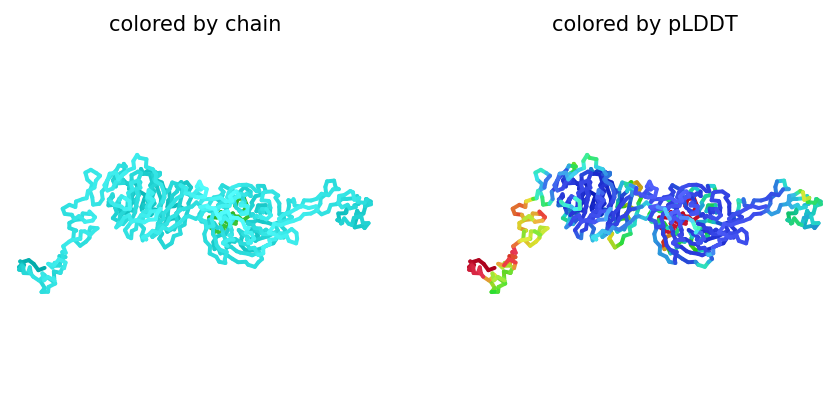

2025-08-18 08:06:14,708 alphafold2_multimer_v3_model_1_seed_002 recycle=0 pLDDT=81.2 pTM=0.692 ipTM=0.49
2025-08-18 08:06:29,688 alphafold2_multimer_v3_model_1_seed_002 recycle=1 pLDDT=83.2 pTM=0.741 ipTM=0.576 tol=2
2025-08-18 08:06:44,664 alphafold2_multimer_v3_model_1_seed_002 recycle=2 pLDDT=83.1 pTM=0.755 ipTM=0.477 tol=1.19
2025-08-18 08:06:59,615 alphafold2_multimer_v3_model_1_seed_002 recycle=3 pLDDT=82.9 pTM=0.759 ipTM=0.491 tol=2.41
2025-08-18 08:07:14,574 alphafold2_multimer_v3_model_1_seed_002 recycle=4 pLDDT=83.1 pTM=0.749 ipTM=0.474 tol=1.03
2025-08-18 08:07:29,565 alphafold2_multimer_v3_model_1_seed_002 recycle=5 pLDDT=83.1 pTM=0.753 ipTM=0.434 tol=0.521
2025-08-18 08:07:44,526 alphafold2_multimer_v3_model_1_seed_002 recycle=6 pLDDT=83.2 pTM=0.751 ipTM=0.433 tol=0.533
2025-08-18 08:07:44,527 alphafold2_multimer_v3_model_1_seed_002 took 104.9s (6 recycles)


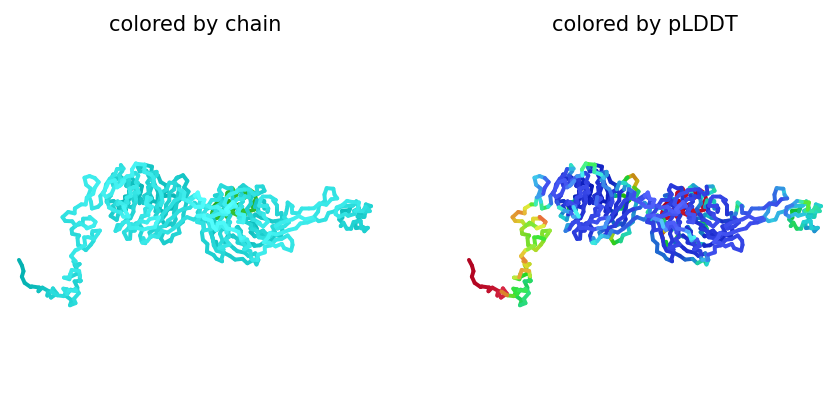

2025-08-18 08:08:01,378 alphafold2_multimer_v3_model_2_seed_002 recycle=0 pLDDT=81.8 pTM=0.725 ipTM=0.64
2025-08-18 08:08:16,410 alphafold2_multimer_v3_model_2_seed_002 recycle=1 pLDDT=83.5 pTM=0.754 ipTM=0.49 tol=1.95
2025-08-18 08:08:31,445 alphafold2_multimer_v3_model_2_seed_002 recycle=2 pLDDT=84.1 pTM=0.771 ipTM=0.491 tol=0.936
2025-08-18 08:08:46,464 alphafold2_multimer_v3_model_2_seed_002 recycle=3 pLDDT=83.9 pTM=0.767 ipTM=0.467 tol=1.62
2025-08-18 08:09:01,475 alphafold2_multimer_v3_model_2_seed_002 recycle=4 pLDDT=84.1 pTM=0.757 ipTM=0.458 tol=0.864
2025-08-18 08:09:16,480 alphafold2_multimer_v3_model_2_seed_002 recycle=5 pLDDT=84.1 pTM=0.757 ipTM=0.37 tol=1.52
2025-08-18 08:09:31,473 alphafold2_multimer_v3_model_2_seed_002 recycle=6 pLDDT=83.7 pTM=0.753 ipTM=0.365 tol=0.928
2025-08-18 08:09:31,474 alphafold2_multimer_v3_model_2_seed_002 took 105.2s (6 recycles)


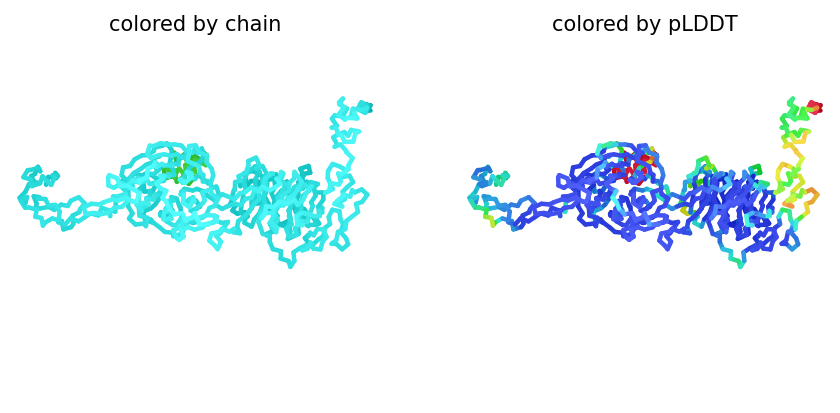

2025-08-18 08:09:48,004 alphafold2_multimer_v3_model_3_seed_002 recycle=0 pLDDT=82.7 pTM=0.691 ipTM=0.528
2025-08-18 08:10:03,017 alphafold2_multimer_v3_model_3_seed_002 recycle=1 pLDDT=83.2 pTM=0.737 ipTM=0.5 tol=1.69
2025-08-18 08:10:17,982 alphafold2_multimer_v3_model_3_seed_002 recycle=2 pLDDT=82.8 pTM=0.743 ipTM=0.537 tol=0.91
2025-08-18 08:10:32,941 alphafold2_multimer_v3_model_3_seed_002 recycle=3 pLDDT=83 pTM=0.752 ipTM=0.548 tol=1.83
2025-08-18 08:10:47,885 alphafold2_multimer_v3_model_3_seed_002 recycle=4 pLDDT=82.7 pTM=0.734 ipTM=0.513 tol=0.831
2025-08-18 08:11:02,857 alphafold2_multimer_v3_model_3_seed_002 recycle=5 pLDDT=83.4 pTM=0.746 ipTM=0.544 tol=0.592
2025-08-18 08:11:17,813 alphafold2_multimer_v3_model_3_seed_002 recycle=6 pLDDT=82.8 pTM=0.741 ipTM=0.51 tol=0.456
2025-08-18 08:11:17,814 alphafold2_multimer_v3_model_3_seed_002 took 104.9s (6 recycles)


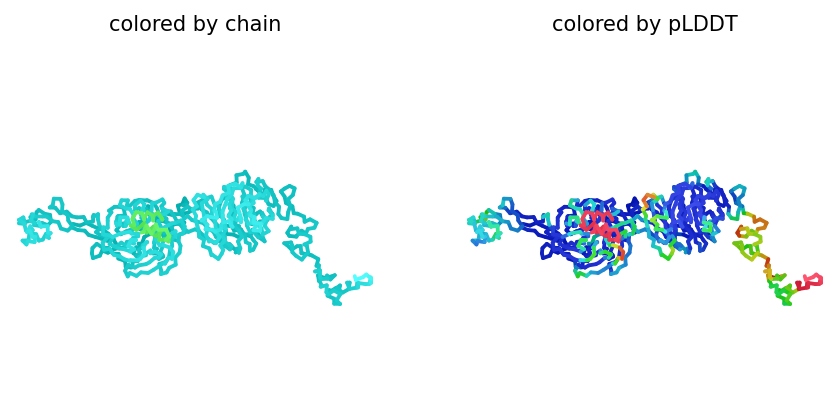

2025-08-18 08:11:34,307 alphafold2_multimer_v3_model_4_seed_002 recycle=0 pLDDT=81.2 pTM=0.703 ipTM=0.442
2025-08-18 08:11:49,357 alphafold2_multimer_v3_model_4_seed_002 recycle=1 pLDDT=82.8 pTM=0.742 ipTM=0.327 tol=2.11
2025-08-18 08:12:04,355 alphafold2_multimer_v3_model_4_seed_002 recycle=2 pLDDT=82.9 pTM=0.757 ipTM=0.437 tol=1.22
2025-08-18 08:12:19,351 alphafold2_multimer_v3_model_4_seed_002 recycle=3 pLDDT=83.2 pTM=0.766 ipTM=0.499 tol=1.5
2025-08-18 08:12:34,346 alphafold2_multimer_v3_model_4_seed_002 recycle=4 pLDDT=83.4 pTM=0.758 ipTM=0.472 tol=0.965
2025-08-18 08:12:49,326 alphafold2_multimer_v3_model_4_seed_002 recycle=5 pLDDT=83.1 pTM=0.751 ipTM=0.411 tol=0.627
2025-08-18 08:13:04,303 alphafold2_multimer_v3_model_4_seed_002 recycle=6 pLDDT=83.1 pTM=0.755 ipTM=0.441 tol=0.641
2025-08-18 08:13:04,304 alphafold2_multimer_v3_model_4_seed_002 took 105.1s (6 recycles)


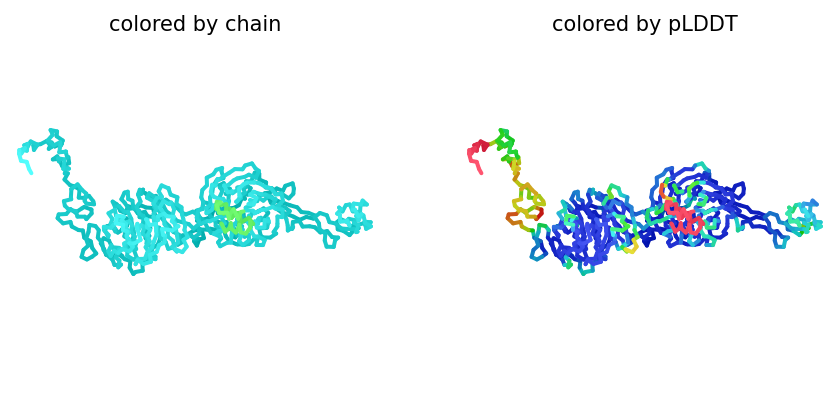

2025-08-18 08:13:20,811 alphafold2_multimer_v3_model_5_seed_002 recycle=0 pLDDT=81.2 pTM=0.723 ipTM=0.459
2025-08-18 08:13:35,839 alphafold2_multimer_v3_model_5_seed_002 recycle=1 pLDDT=81.9 pTM=0.751 ipTM=0.467 tol=1.73
2025-08-18 08:13:50,849 alphafold2_multimer_v3_model_5_seed_002 recycle=2 pLDDT=82.1 pTM=0.76 ipTM=0.502 tol=1.46
2025-08-18 08:14:05,867 alphafold2_multimer_v3_model_5_seed_002 recycle=3 pLDDT=82.5 pTM=0.761 ipTM=0.493 tol=1.89
2025-08-18 08:14:20,856 alphafold2_multimer_v3_model_5_seed_002 recycle=4 pLDDT=82.2 pTM=0.748 ipTM=0.492 tol=1.13
2025-08-18 08:14:35,859 alphafold2_multimer_v3_model_5_seed_002 recycle=5 pLDDT=82.4 pTM=0.751 ipTM=0.496 tol=0.637
2025-08-18 08:14:50,844 alphafold2_multimer_v3_model_5_seed_002 recycle=6 pLDDT=82.1 pTM=0.747 ipTM=0.435 tol=0.76
2025-08-18 08:14:50,844 alphafold2_multimer_v3_model_5_seed_002 took 105.1s (6 recycles)


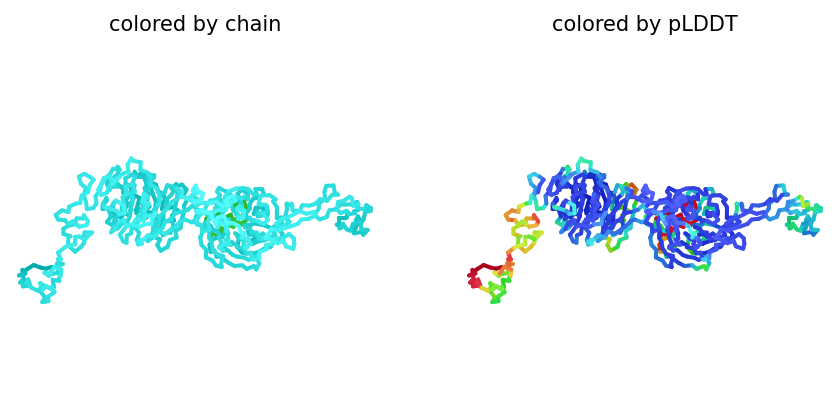

2025-08-18 08:15:07,312 alphafold2_multimer_v3_model_1_seed_003 recycle=0 pLDDT=81.2 pTM=0.667 ipTM=0.519
2025-08-18 08:15:22,277 alphafold2_multimer_v3_model_1_seed_003 recycle=1 pLDDT=82.5 pTM=0.716 ipTM=0.444 tol=2.37
2025-08-18 08:15:37,261 alphafold2_multimer_v3_model_1_seed_003 recycle=2 pLDDT=82.9 pTM=0.738 ipTM=0.46 tol=1.18
2025-08-18 08:15:52,206 alphafold2_multimer_v3_model_1_seed_003 recycle=3 pLDDT=82.5 pTM=0.741 ipTM=0.411 tol=0.699
2025-08-18 08:16:07,152 alphafold2_multimer_v3_model_1_seed_003 recycle=4 pLDDT=82.4 pTM=0.746 ipTM=0.402 tol=0.537
2025-08-18 08:16:22,112 alphafold2_multimer_v3_model_1_seed_003 recycle=5 pLDDT=83.2 pTM=0.755 ipTM=0.408 tol=1.17
2025-08-18 08:16:37,066 alphafold2_multimer_v3_model_1_seed_003 recycle=6 pLDDT=82.8 pTM=0.743 ipTM=0.344 tol=0.809
2025-08-18 08:16:37,066 alphafold2_multimer_v3_model_1_seed_003 took 104.8s (6 recycles)


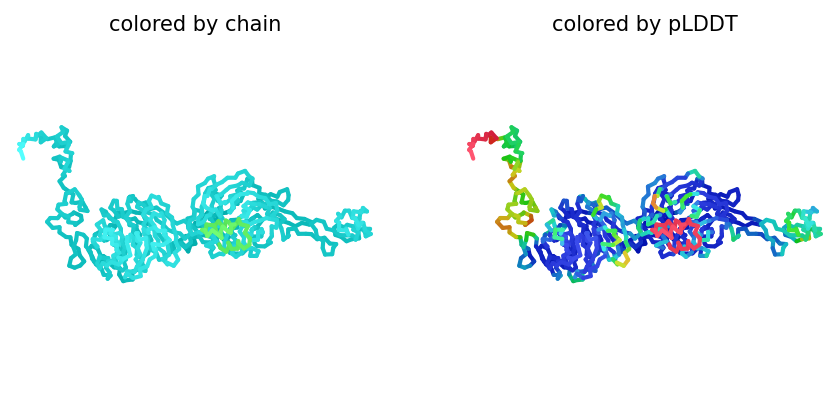

2025-08-18 08:16:53,545 alphafold2_multimer_v3_model_2_seed_003 recycle=0 pLDDT=81.8 pTM=0.707 ipTM=0.643
2025-08-18 08:17:08,566 alphafold2_multimer_v3_model_2_seed_003 recycle=1 pLDDT=83.6 pTM=0.738 ipTM=0.489 tol=2.8
2025-08-18 08:17:23,597 alphafold2_multimer_v3_model_2_seed_003 recycle=2 pLDDT=84.1 pTM=0.756 ipTM=0.431 tol=0.956
2025-08-18 08:17:38,619 alphafold2_multimer_v3_model_2_seed_003 recycle=3 pLDDT=83.9 pTM=0.759 ipTM=0.42 tol=1.12
2025-08-18 08:17:53,638 alphafold2_multimer_v3_model_2_seed_003 recycle=4 pLDDT=84.1 pTM=0.763 ipTM=0.417 tol=1.28
2025-08-18 08:18:08,638 alphafold2_multimer_v3_model_2_seed_003 recycle=5 pLDDT=84.1 pTM=0.754 ipTM=0.287 tol=1.41
2025-08-18 08:18:23,646 alphafold2_multimer_v3_model_2_seed_003 recycle=6 pLDDT=83.7 pTM=0.747 ipTM=0.229 tol=1.7
2025-08-18 08:18:23,647 alphafold2_multimer_v3_model_2_seed_003 took 105.2s (6 recycles)


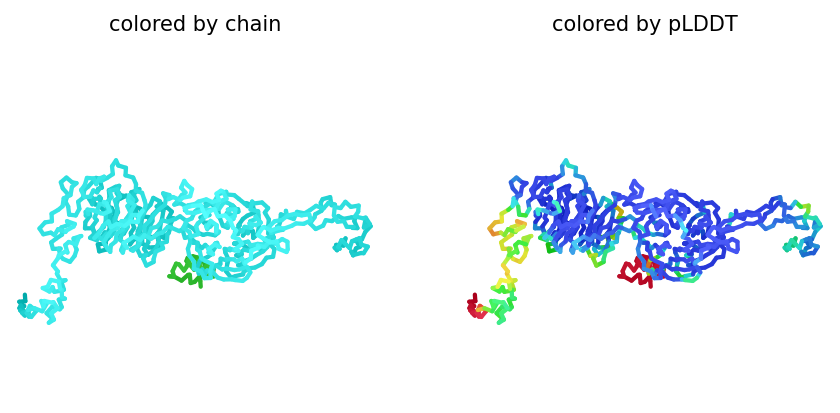

2025-08-18 08:18:40,101 alphafold2_multimer_v3_model_3_seed_003 recycle=0 pLDDT=81.4 pTM=0.668 ipTM=0.564
2025-08-18 08:18:55,073 alphafold2_multimer_v3_model_3_seed_003 recycle=1 pLDDT=82.9 pTM=0.72 ipTM=0.436 tol=2.65
2025-08-18 08:19:10,041 alphafold2_multimer_v3_model_3_seed_003 recycle=2 pLDDT=83.1 pTM=0.74 ipTM=0.542 tol=1.78
2025-08-18 08:19:25,003 alphafold2_multimer_v3_model_3_seed_003 recycle=3 pLDDT=82.8 pTM=0.734 ipTM=0.481 tol=0.942
2025-08-18 08:19:39,936 alphafold2_multimer_v3_model_3_seed_003 recycle=4 pLDDT=82 pTM=0.729 ipTM=0.501 tol=1.04
2025-08-18 08:19:54,904 alphafold2_multimer_v3_model_3_seed_003 recycle=5 pLDDT=83.4 pTM=0.741 ipTM=0.531 tol=1.01
2025-08-18 08:20:09,852 alphafold2_multimer_v3_model_3_seed_003 recycle=6 pLDDT=82.9 pTM=0.737 ipTM=0.519 tol=0.433
2025-08-18 08:20:09,853 alphafold2_multimer_v3_model_3_seed_003 took 104.8s (6 recycles)


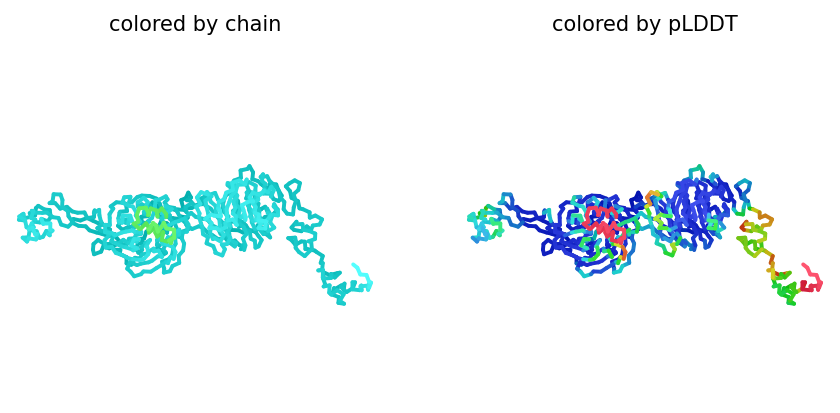

2025-08-18 08:20:26,317 alphafold2_multimer_v3_model_4_seed_003 recycle=0 pLDDT=80.8 pTM=0.684 ipTM=0.458
2025-08-18 08:20:41,338 alphafold2_multimer_v3_model_4_seed_003 recycle=1 pLDDT=83.2 pTM=0.736 ipTM=0.419 tol=2.02
2025-08-18 08:20:56,355 alphafold2_multimer_v3_model_4_seed_003 recycle=2 pLDDT=82.6 pTM=0.748 ipTM=0.399 tol=0.929
2025-08-18 08:21:11,373 alphafold2_multimer_v3_model_4_seed_003 recycle=3 pLDDT=83.2 pTM=0.752 ipTM=0.298 tol=2.43
2025-08-18 08:21:26,342 alphafold2_multimer_v3_model_4_seed_003 recycle=4 pLDDT=82.4 pTM=0.743 ipTM=0.281 tol=1.37
2025-08-18 08:21:41,338 alphafold2_multimer_v3_model_4_seed_003 recycle=5 pLDDT=83.6 pTM=0.753 ipTM=0.382 tol=2.56
2025-08-18 08:21:56,342 alphafold2_multimer_v3_model_4_seed_003 recycle=6 pLDDT=83.7 pTM=0.759 ipTM=0.418 tol=0.473
2025-08-18 08:21:56,343 alphafold2_multimer_v3_model_4_seed_003 took 105.1s (6 recycles)


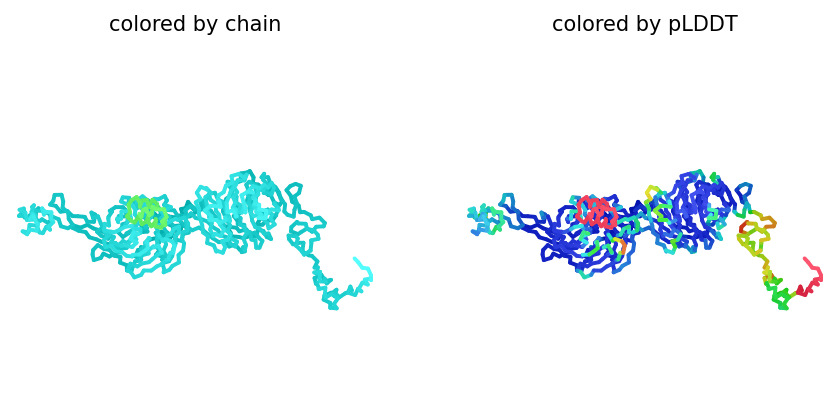

2025-08-18 08:22:12,789 alphafold2_multimer_v3_model_5_seed_003 recycle=0 pLDDT=79.4 pTM=0.682 ipTM=0.375
2025-08-18 08:22:27,794 alphafold2_multimer_v3_model_5_seed_003 recycle=1 pLDDT=81.9 pTM=0.736 ipTM=0.415 tol=1.65
2025-08-18 08:22:42,767 alphafold2_multimer_v3_model_5_seed_003 recycle=2 pLDDT=81.7 pTM=0.742 ipTM=0.453 tol=1.44
2025-08-18 08:22:57,759 alphafold2_multimer_v3_model_5_seed_003 recycle=3 pLDDT=82.3 pTM=0.749 ipTM=0.431 tol=1.52
2025-08-18 08:23:12,745 alphafold2_multimer_v3_model_5_seed_003 recycle=4 pLDDT=82.1 pTM=0.752 ipTM=0.485 tol=1.46
2025-08-18 08:23:27,737 alphafold2_multimer_v3_model_5_seed_003 recycle=5 pLDDT=82.4 pTM=0.754 ipTM=0.452 tol=1.27
2025-08-18 08:23:42,703 alphafold2_multimer_v3_model_5_seed_003 recycle=6 pLDDT=81.8 pTM=0.744 ipTM=0.461 tol=1.09
2025-08-18 08:23:42,704 alphafold2_multimer_v3_model_5_seed_003 took 104.9s (6 recycles)


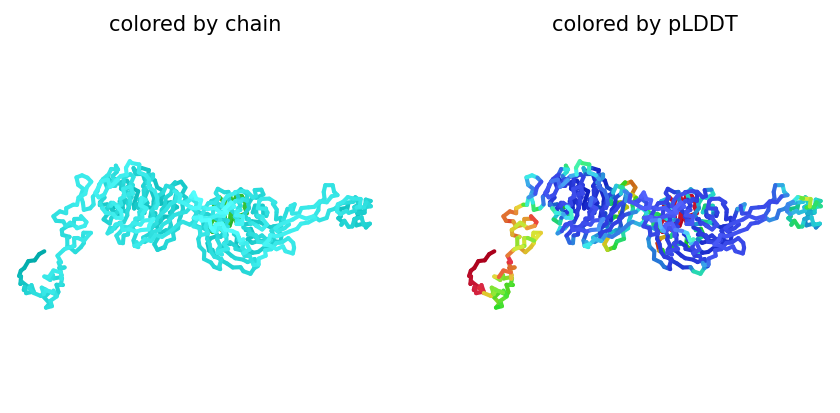

2025-08-18 08:23:44,115 reranking models by 'multimer' metric
2025-08-18 08:23:44,116 rank_001_alphafold2_multimer_v3_model_3_seed_000 pLDDT=83.2 pTM=0.732 ipTM=0.533
2025-08-18 08:23:44,116 rank_002_alphafold2_multimer_v3_model_4_seed_000 pLDDT=83.5 pTM=0.761 ipTM=0.514
2025-08-18 08:23:44,116 rank_003_alphafold2_multimer_v3_model_3_seed_003 pLDDT=82.9 pTM=0.737 ipTM=0.519
2025-08-18 08:23:44,116 rank_004_alphafold2_multimer_v3_model_3_seed_002 pLDDT=82.8 pTM=0.741 ipTM=0.51
2025-08-18 08:23:44,116 rank_005_alphafold2_multimer_v3_model_5_seed_000 pLDDT=82.8 pTM=0.751 ipTM=0.493
2025-08-18 08:23:44,116 rank_006_alphafold2_multimer_v3_model_3_seed_001 pLDDT=82.1 pTM=0.734 ipTM=0.473
2025-08-18 08:23:44,117 rank_007_alphafold2_multimer_v3_model_5_seed_003 pLDDT=81.8 pTM=0.744 ipTM=0.461
2025-08-18 08:23:44,117 rank_008_alphafold2_multimer_v3_model_1_seed_001 pLDDT=82.9 pTM=0.751 ipTM=0.452
2025-08-18 08:23:44,117 rank_009_alphafold2_multimer_v3_model_5_seed_001 pLDDT=81.2 pTM=0.738 ipTM=

0

In [5]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
    calc_extra_ptm=calc_extra_ptm,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

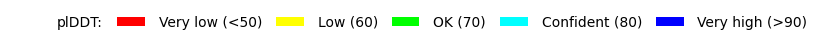

In [6]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()


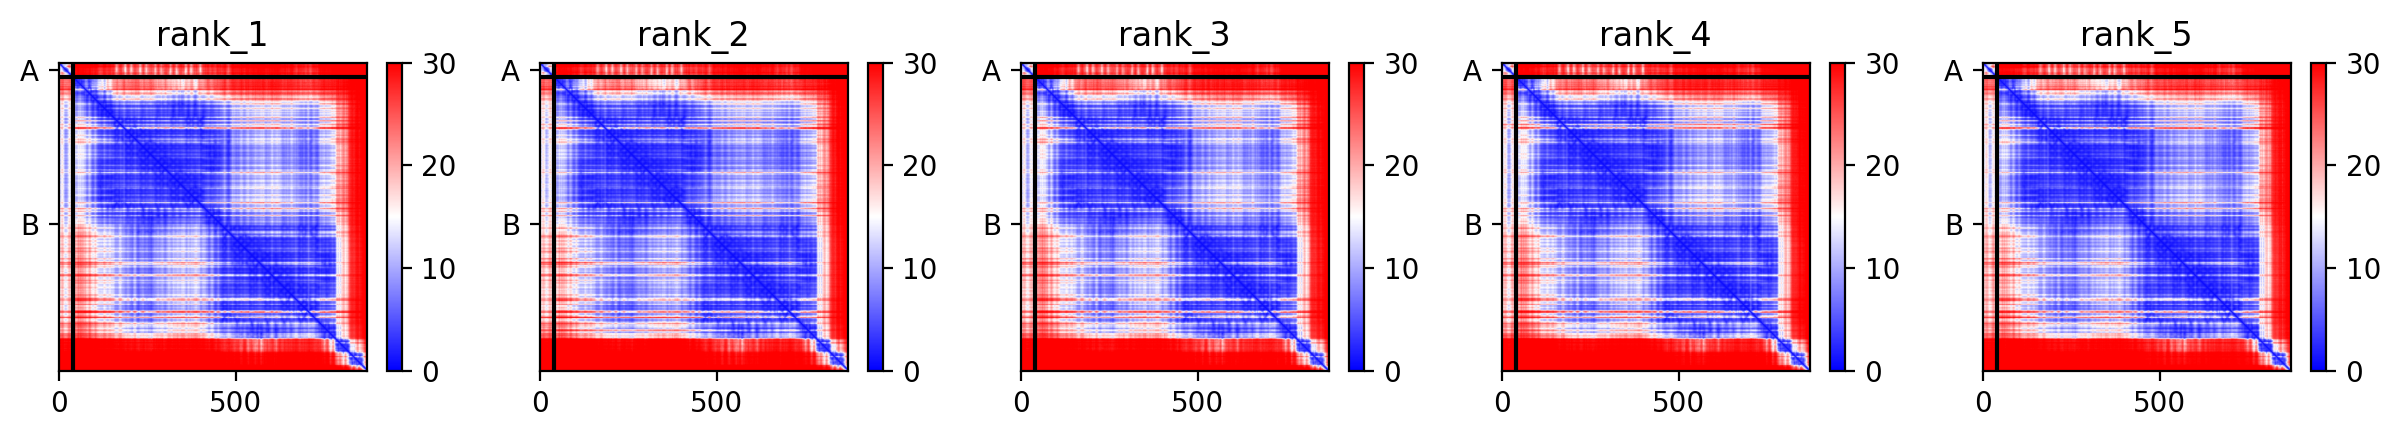
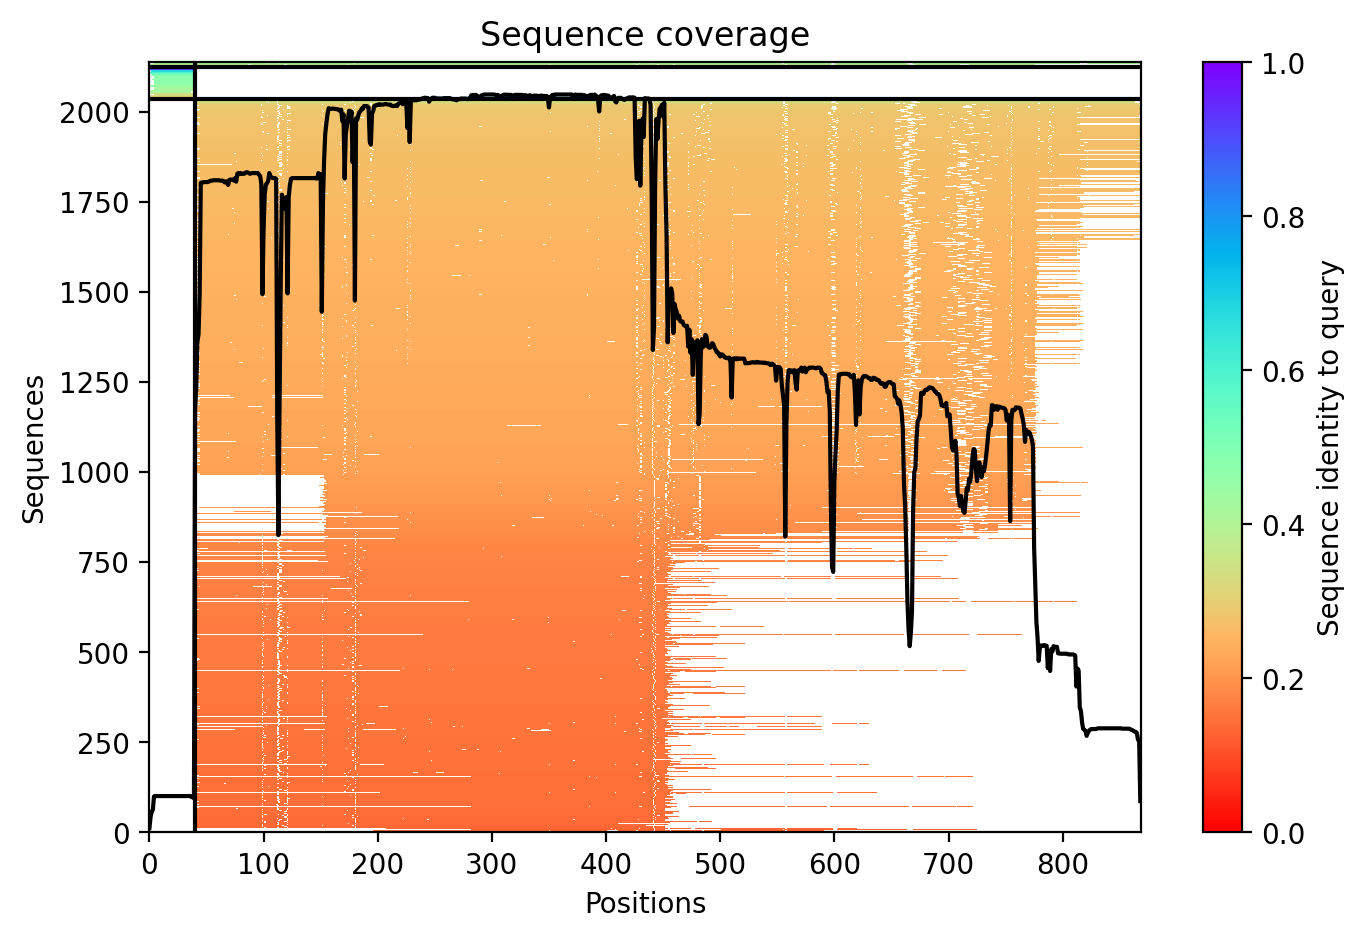
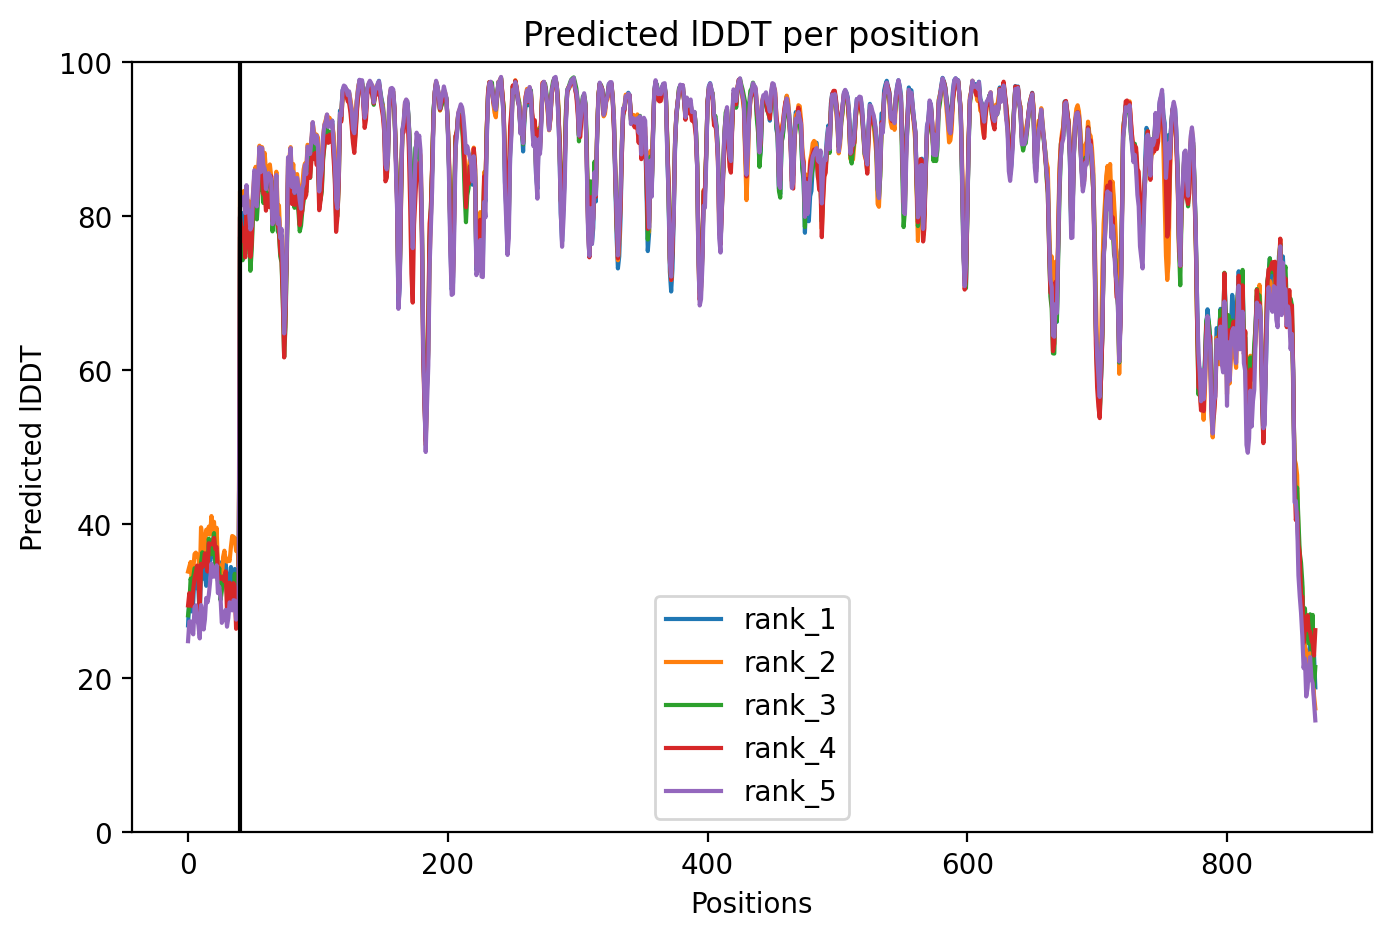

In [7]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = ""
pae_file = os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png")
if os.path.isfile(pae_file):
    pae = image_to_data_url(pae_file)
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  { '<!--' if pae == '' else '' }<img src="{pae}" class="full" />{ '-->' if pae == '' else '' }
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))

In [8]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Instructions <a name="Instructions"></a>
For detailed instructions, tips and tricks, see recently published paper at [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5)

**Quick start**
1. Paste your protein sequence(s) in the input field.
2. Press "Runtime" -> "Run all".
3. The pipeline consists of 5 steps. The currently running step is indicated by a circle with a stop sign next to it.

**Result zip file contents**

1. PDB formatted structures sorted by avg. pLDDT and complexes are sorted by pTMscore. (unrelaxed and relaxed if `use_amber` is enabled).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. A `predicted_aligned_error_v1.json` using [AlphaFold-DB's format](https://alphafold.ebi.ac.uk/faq#faq-7) and a `scores.json` for each model which contains an array (list of lists) for PAE, a list with the average pLDDT and the pTMscore.
7. BibTeX file with citations for all used tools and databases.

At the end of the job a download modal box will pop up with a `jobname.result.zip` file. Additionally, if the `save_to_google_drive` option was selected, the `jobname.result.zip` will be uploaded to your Google Drive.

**MSA generation for complexes**

For the complex prediction we use unpaired and paired MSAs. Unpaired MSA is generated the same way as for the protein structures prediction by searching the UniRef100 and environmental sequences three iterations each.

The paired MSA is generated by searching the UniRef100 database and pairing the best hits sharing the same NCBI taxonomic identifier (=species or sub-species). We only pair sequences if all of the query sequences are present for the respective taxonomic identifier.

**Using a custom MSA as input**

To predict the structure with a custom MSA (A3M formatted): (1) Change the `msa_mode`: to "custom", (2) Wait for an upload box to appear at the end of the "MSA options ..." box. Upload your A3M. The first fasta entry of the A3M must be the query sequence without gaps.

It is also possilbe to provide custom MSAs for complex predictions. Read more about the format [here](https://github.com/sokrypton/ColabFold/issues/76).

As an alternative for MSA generation the [HHblits Toolkit server](https://toolkit.tuebingen.mpg.de/tools/hhblits) can be used. After submitting your query, click "Query Template MSA" -> "Download Full A3M". Download the A3M file and upload it in this notebook.

**PDB100** <a name="pdb100"></a>

As of 23/06/08, we have transitioned from using the PDB70 to a 100% clustered PDB, the PDB100. The construction methodology of PDB100 differs from that of PDB70.

The PDB70 was constructed by running each PDB70 representative sequence through [HHblits](https://github.com/soedinglab/hh-suite) against the [Uniclust30](https://uniclust.mmseqs.com/). On the other hand, the PDB100 is built by searching each PDB100 representative structure with [Foldseek](https://github.com/steineggerlab/foldseek) against the [AlphaFold Database](https://alphafold.ebi.ac.uk).

To maintain compatibility with older Notebook versions and local installations, the generated files and API responses will continue to be named "PDB70", even though we're now using the PDB100.

**Using custom templates** <a name="custom_templates"></a>

To predict the structure with a custom template (PDB or mmCIF formatted): (1) change the `template_mode` to "custom" in the execute cell and (2) wait for an upload box to appear at the end of the "Input Protein" box. Select and upload your templates (multiple choices are possible).

* Templates must follow the four letter PDB naming with lower case letters.

* Templates in mmCIF format must contain `_entity_poly_seq`. An error is thrown if this field is not present. The field `_pdbx_audit_revision_history.revision_date` is automatically generated if it is not present.

* Templates in PDB format are automatically converted to the mmCIF format. `_entity_poly_seq` and `_pdbx_audit_revision_history.revision_date` are automatically generated.

If you encounter problems, please report them to this [issue](https://github.com/sokrypton/ColabFold/issues/177).

**Comparison to the full AlphaFold2 and AlphaFold2 Colab**

This notebook replaces the homology detection and MSA pairing of AlphaFold2 with MMseqs2. For a comparison against the [AlphaFold2 Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) and the full [AlphaFold2](https://github.com/deepmind/alphafold) system read our [paper](https://www.nature.com/articles/s41592-022-01488-1).

**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* Computing resources: Our MMseqs2 API can handle ~20-50k requests per day.
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or MGnify.
* We recommend to additionally use the full [AlphaFold2 pipeline](https://github.com/deepmind/alphafold).

**Description of the plots**
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/sokrypton/ColabFold/issues

**License**

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

**Acknowledgments**
- We thank the AlphaFold team for developing an excellent model and open sourcing the software.

- [KOBIC](https://kobic.re.kr) and [Söding Lab](https://www.mpinat.mpg.de/soeding) for providing the computational resources for the MMseqs2 MSA server.

- Richard Evans for helping to benchmark the ColabFold's Alphafold-multimer support.

- [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin, without whom these notebooks would be quite boring!

- Do-Yoon Kim for creating the ColabFold logo.

- A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).
